<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/European_Call_jax_1stock_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

In [7]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
  return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.0807]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.2597*0.2597
initial_stocks = jnp.array([0.7178]*numstocks) # must be float
T = 1.0
K = 0.2106

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T)

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T)

0.5235912
[1.0000885]


# Construct Neural Net

In [1]:
%%writefile cupy_dataset.py
# version 1, 2, 6
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(0.75 + np.random.random(self.N_STOCKS) * 0.5)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(0.15 + np.random.random(self.N_STOCKS) * 0.3)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(0.25 + np.random.random(1) * 0.35), self.N_STOCKS)
          drift = r

          T = self.T
          K = 0.75 + np.random.random(1) * 0.5

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:] = cupy.array(Deltas, dtype=cupy.float32) # remember to change this!

          # T, K, S, sigma, mu, r
          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 1000000, batch = 2, seed = np.random.randint(10000), stocks=1) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Writing cupy_dataset.py


In [2]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.35, 0.35]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.25, 0.25]*1)) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [3]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 5.1 MB/s 


In [7]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 100000, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 0]).cuda()  # let delta weight = 0 for testing
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 100)

loss 2408.8115234375 average time 0.21569903545000102 iter num 20
loss 2126.212890625 average time 0.12378502192499923 iter num 40
loss 2588.671142578125 average time 0.09295705038333797 iter num 60
loss 921.111572265625 average time 0.07758783802500915 iter num 80
loss 1434.099853515625 average time 0.0684344519600097 iter num 100
loss 89.68195343017578 average time 0.10293295500001705 iter num 20
loss 25.545438766479492 average time 0.06765549510001279 iter num 40
loss 18.984630584716797 average time 0.055631484150004934 iter num 60
loss 12.278401374816895 average time 0.04941242690000536 iter num 80
loss 15.778316497802734 average time 0.04580528509999795 iter num 100
loss 10.017118453979492 average time 0.10074550609999733 iter num 20
loss 16.154296875 average time 0.06602838105000046 iter num 40
loss 10.468088150024414 average time 0.05471895543333479 iter num 60
loss 3.5554184913635254 average time 0.04910922859998834 iter num 80
loss 5.760096549987793 average time 0.045691191629

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

**Save Model**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import torch
model_save_name = 'jax_european_1stock_test1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import torch
model_save_name = 'jax_european_1stock_test1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [16]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1, bias=True)
)


**Continue to train model**

In [45]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 16, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 0]).cuda()  # let delta weight = 0 for testing
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 10

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 20)

model_save_name = 'jax_european_1stock_test1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 13.031719207763672 average time 0.3516769881000073 iter num 10
loss 2.8753252029418945 average time 0.1843993639002292 iter num 20
loss 6.898102283477783 average time 0.1290628192336347 iter num 30
loss 0.5391082167625427 average time 0.10116679775028388 iter num 40
loss 0.7777198553085327 average time 0.08436501544019848 iter num 50
loss 0.3032364845275879 average time 0.07326824943350706 iter num 60
loss 0.3129631280899048 average time 0.06527927104299514 iter num 70
loss 0.04416505992412567 average time 0.05930497996255326 iter num 80
loss 0.188725084066391 average time 0.05463837472238487 iter num 90
loss 0.11835906654596329 average time 0.05103864909018739 iter num 100
loss 0.1419709175825119 average time 0.35059288259944876 iter num 10
loss 0.2971019148826599 average time 0.1840592314494643 iter num 20
loss 0.39013251662254333 average time 0.12847000879968012 iter num 30
loss 0.12671756744384766 average time 0.10075981384970874 iter num 40
loss 0.38977205753326416 average ti

#Results

In [16]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.3, 0.3]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.098688, 0.627409)

price: tensor([[1.6141]], device='cuda:0', grad_fn=<AddmmBackward>)


tensor([0.3334], device='cuda:0')

In [8]:
numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.3]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.0]*numstocks) # must be float
T = 1.0
K = 1.0

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))

0.27124467
[0.90766466]


# Delta

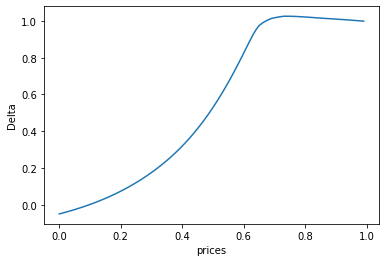

In [17]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[1, 0.5, S, 0.25, 0.05, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(0, 1, 0.01)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig